# _Updates to make -- from Carolyn's notes, 082018:_

housing-jobs ratio 2010-2017 and 2000-**2017**?? not 2000-2010?
What about
- 2008-2017 housing/jobs
- 2010-2017 permits-jobs
?

----

Author: Dana Chermesh, Regional Planning intern;
July 2018

### _US Metros comparison  Notebook no.5_
# Housing-Jobs balance
### - _Employment data were obtained from: BLS-QCEW_
Data Source: [Bureau of Labor Statistics, Quarterly Census of Employment and Wages](https://www.bls.gov/cew/datatoc.htm) (BLS-QCEW)
### - _Housing data were obtained from PEP/2017/housing_

---- 
# 0 - Imports

In [ ]:
import requests
import pandas as pd
import numpy as np

from __future__ import print_function, division
import matplotlib.pylab as pl
# from pandas.tools.plotting import scatter_matrix
import seaborn as sns
sns.set_style('whitegrid')
# import json

# Spatial
import geopandas as gpd
import fiona
import shapely

import statsmodels.formula.api as smf
import statsmodels.api as sm

%pylab inline

##  Reading in geo-coded dataset
created on a different notebook, please refer to _**0_US_Metro_Comparison_Geographies**_

In [2]:
geo = pd.read_csv('../rp-USmetros_comparison/data/USmetros_full.csv').iloc[:,:-2] \
            .drop(['Unnamed: 0', 'SHAPE_AREA'], axis=1)
geo['STCO'] = geo['STCO'].apply(lambda x: '{0:0>5}'.format(x))

print(geo.shape)
geo.head()

(270, 4)


,CSA,CSA_name,County_name,STCO
0,488,"San Jose-San Francisco-Oakland, CA",Alameda,06001
1,488,"San Jose-San Francisco-Oakland, CA",Contra Costa,06013
2,488,"San Jose-San Francisco-Oakland, CA",Marin,06041
3,488,"San Jose-San Francisco-Oakland, CA",Napa,06055
4,488,"San Jose-San Francisco-Oakland, CA",San Benito,06069


In [3]:
geo.dtypes

CSA             int64
CSA_name       object
County_name    object
STCO           object
dtype: object

In [4]:
STCO = list(geo['STCO'])

print(type(STCO))
print(len(STCO))
STCO[:10]

<class 'list'>
270


['06001',
 '06013',
 '06041',
 '06055',
 '06069',
 '06075',
 '06077',
 '06081',
 '06085',
 '06087']

# Housing / Jobs Balance analysis

- PEP/2017/housing
- BLS QCEW 2017 annually

# 1. Counties - for mapping

# Total Employement 2000-2017
- 'annual_avg_emplvl'

The data set had been created in notebook **4-EMPLOYMENT_BLS-QCEW10-17** in this repo. 

Employment data were obtained from the _**[Bureau of Labor Statistics, Quarterly Census of Employment and Wages](https://www.bls.gov/cew/datatoc.htm) (BLS-QCEW)**_

In [5]:
JobsCO00_17 = pd.read_csv('exports/Jobs00-17CO.csv').iloc[:,:-2]

JobsCO00_17.rename(columns={'Unnamed: 0':'STCO'}, inplace=True)

JobsCO00_17['STCO'] = JobsCO00_17['STCO'].astype(str)
JobsCO00_17['STCO'] = JobsCO00_17['STCO'].apply(lambda x: '{0:0>5}'.format(x))

JobsCO00_17 = JobsCO00_17.set_index('STCO')

print(JobsCO00_17.shape)
JobsCO00_17.head()

(269, 2)


,Total_emp00,Total_emp17
STCO,,
06001,697215,772071
06013,337924,366799
06037,4110915,4394364
06041,112454,115421
06055,60552,76765


# 2017

## Total Population from PEP housing 2017
Detailing on Population and Housing Estimates APIs: https://www.census.gov/data/developers/data-sets/popest-popproj/popest.2000-2010_Intercensals.html

- [examples for /data/2017/pep/population](https://api.census.gov/data/2017/pep/population/examples.html)

In [6]:
# POP2017 data for all counties in the US
POP2017 = pd.read_json('https://api.census.gov/data/2017/pep/population?get='+
                         'POP,GEONAME&for=county:*')

POP2017.columns = POP2017.iloc[0]
POP2017 = POP2017[1:]

POP2017['state'] = POP2017['state'].apply(lambda x: '{0:0>2}'.format(x))
POP2017['county'] = POP2017['county'].apply(lambda x: '{0:0>3}'.format(x))
POP2017['STCO'] = POP2017[['state', 'county']].apply(lambda x: ''.join(x), axis=1)

POP2017 = POP2017.drop(['state', 'county'], axis=1)
POP2017.columns = ['TotalPOP17','Name', 'STCO']

print(POP2017.shape)
POP2017.head()

(3220, 3)


,TotalPOP17,Name,STCO
1,55504,"Autauga County, Alabama",01001
2,212628,"Baldwin County, Alabama",01003
3,25270,"Barbour County, Alabama",01005
4,22668,"Bibb County, Alabama",01007
5,58013,"Blount County, Alabama",01009


## Total Housing from PEP housing 2017

- [examples for /data/2017/pep/housing](https://api.census.gov/data/2017/pep/housing/examples.html)

In [7]:
# HU2017 data for all counties in the US
totalHU17 = pd.read_json('https://api.census.gov/data/2017/pep/housing?get='+
                         'HUEST,GEONAME&for=county:*&DATE=10')

totalHU17.columns = totalHU17.iloc[0]
totalHU17 = totalHU17[1:]

totalHU17['state'] = totalHU17['state'].apply(lambda x: '{0:0>2}'.format(x))
totalHU17['county'] = totalHU17['county'].apply(lambda x: '{0:0>3}'.format(x))
totalHU17['STCO'] = totalHU17[['state', 'county']].apply(lambda x: ''.join(x), axis=1)

totalHU17 = totalHU17.drop(['state', 'county','DATE'], axis=1)
totalHU17.columns = ['TotalHousing17','Name', 'STCO']

print(totalHU17.shape)
totalHU17.head()

(3142, 3)


,TotalHousing17,Name,STCO
1,372981,"Fairfield County, Connecticut",09001
2,379719,"Hartford County, Connecticut",09003
3,88285,"Litchfield County, Connecticut",09005
4,76339,"Middlesex County, Connecticut",09007
5,367195,"New Haven County, Connecticut",09009


## Merge Population + Housing year 2017

In [8]:
PEP17 = POP2017.merge(totalHU17, on='STCO')

PEP17 = PEP17.drop(['Name_x'], axis=1)
PEP17.rename(columns={'Name_y':'Name'}, inplace=True)

print(PEP17.shape)
PEP17.head()

(3142, 4)


,TotalPOP17,STCO,TotalHousing17,Name
0,55504,01001,23495,"Autauga County, Alabama"
1,212628,01003,114162,"Baldwin County, Alabama"
2,25270,01005,11970,"Barbour County, Alabama"
3,22668,01007,9187,"Bibb County, Alabama"
4,58013,01009,24314,"Blount County, Alabama"


---- 

# 2010

## Total Housing 2010 PEP 2010 -- Not in use 

This data set is called "int_housingunits 2000" and it includes both 2000 and 2010 Census Decennials data.

- API Call: api.census.gov/data/2000/pep/int_housingunits
- [examples](https://api.census.gov/data/2000/pep/int_housingunits.html)
- [variables](https://api.census.gov/data/2000/pep/int_housingunits/variables.html) in /data/2000/pep/int_housingunits/variables

In [9]:
# HU2010 data for all counties in the US, from PEP housing 2000-2010
totalHU10 = pd.read_json('https://api.census.gov/data/2000/pep/int_housingunits?get='+
                         'HUEST,GEONAME&for=county:*&DATE=10')

totalHU10.columns = totalHU10.iloc[0]
totalHU10 = totalHU10[1:]

totalHU10['state'] = totalHU10['state'].apply(lambda x: '{0:0>2}'.format(x))
totalHU10['county'] = totalHU10['county'].apply(lambda x: '{0:0>3}'.format(x))
totalHU10['STCO'] = totalHU10[['state', 'county']].apply(lambda x: ''.join(x), axis=1)

totalHU10 = totalHU10.drop(['state', 'county', 'DATE'], axis=1)
totalHU10.columns = ['TotalHousing10','Name', 'STCO']

print(totalHU10.shape)
totalHU10.head()

(3143, 3)


,TotalHousing10,Name,STCO
1,358484,"Fairfield County, Connecticut",09001
2,372325,"Hartford County, Connecticut",09003
3,86754,"Litchfield County, Connecticut",09005
4,74172,"Middlesex County, Connecticut",09007
5,359866,"New Haven County, Connecticut",09009


## Total Pop + Total Housing 2010 from US Census Bureau Decennial Census 2010

In [10]:
# total HU for all counties in the US, 2010
totalHU10_sf = pd.read_json('https://api.census.gov/data/2010/sf1?get='+
                            'P0010001,H00010001,NAME&for=county:*')
totalHU10_sf.columns = totalHU10_sf.iloc[0]
totalHU10_sf = totalHU10_sf[1:]

totalHU10_sf['state'] = totalHU10_sf['state'].apply(lambda x: '{0:0>2}'.format(x))
totalHU10_sf['county'] = totalHU10_sf['county'].apply(lambda x: '{0:0>3}'.format(x))
totalHU10_sf['STCO'] = totalHU10_sf[['state', 'county']].apply(lambda x: ''.join(x), axis=1)

totalHU10_sf = totalHU10_sf.drop(['state', 'county'], axis=1)
totalHU10_sf.columns = ['TotalPop10','TotalHousing10','Name', 'STCO']

print(totalHU10_sf.shape)
totalHU10_sf.head()

(3221, 4)


,TotalPop10,TotalHousing10,Name,STCO
1,54571,22135,Autauga County,01001
2,182265,104061,Baldwin County,01003
3,27457,11829,Barbour County,01005
4,22915,8981,Bibb County,01007
5,57322,23887,Blount County,01009


----

# 2000

## Total Pop + Total Housing 2000 from US Census Bureau Decennial Census 2000

In [11]:
# total HU for all counties in the US, 2000
totalHU00 = pd.read_json('https://api.census.gov/data/2000/sf1?get='+
                         'P001001,H001001,NAME&for=county:*')
totalHU00.columns = totalHU00.iloc[0]
totalHU00 = totalHU00[1:]

totalHU00['state'] = totalHU00['state'].apply(lambda x: '{0:0>2}'.format(x))
totalHU00['county'] = totalHU00['county'].apply(lambda x: '{0:0>3}'.format(x))
totalHU00['STCO'] = totalHU00[['state', 'county']].apply(lambda x: ''.join(x), axis=1)

totalHU00 = totalHU00.drop(['state', 'county'], axis=1)
totalHU00.columns = ['TotalPop00','TotalHousing00','Name', 'STCO']

print(totalHU00.shape)
totalHU00.head()

(3141, 4)


,TotalPop00,TotalHousing00,Name,STCO
1,43671,17662,Autauga County,01001
2,140415,74285,Baldwin County,01003
3,29038,12461,Barbour County,01005
4,20826,8345,Bibb County,01007
5,51024,21158,Blount County,01009


----
# Population + Housing + Employment change 00-17

## Merge pop+housing 2000, 2017, then merge with Jobs

In [12]:
# merge pop+hou 2000 with pop+hou 2017
popHou00_17 = totalHU00.merge(PEP17, on='STCO')

popHou00_17 = popHou00_17.drop(['Name_x'], axis=1)
popHou00_17.rename(columns={'Name_y':'Name'}, inplace=True)
popHou00_17 = popHou00_17.set_index(['STCO','Name'])
# make dtypes numeric
popHou00_17 = popHou00_17.apply(pd.to_numeric,
                                errors='coerce').reset_index()

# merge popHou with Jobs00-17
ALL_co00_17 = popHou00_17.merge(JobsCO00_17, left_on='STCO',
                                right_index=True).set_index(['STCO','Name'])

print(ALL_co00_17.shape)
print(ALL_co00_17.dtypes)
ALL_co00_17.head()

(269, 6)
TotalPop00        int64
TotalHousing00    int64
TotalPOP17        int64
TotalHousing17    int64
Total_emp00       int64
Total_emp17       int64
dtype: object


,,TotalPop00,TotalHousing00,TotalPOP17,TotalHousing17,Total_emp00,Total_emp17
STCO,Name,,,,,,
06001,"Alameda County, California",1443741,540183,1663190,606052,697215,772071
06013,"Contra Costa County, California",948816,354577,1147439,414007,337924,366799
06037,"Los Angeles County, California",9519338,3270909,10163507,3542636,4110915,4394364
06041,"Marin County, California",247289,104990,260955,113126,112454,115421
06055,"Napa County, California",124279,48554,140973,55847,60552,76765


### Exporting to .csv

In [13]:
ALL_co00_17.to_csv('exports/popHouEmp_co00_17.csv')

## Not exported; for plotting - change claculations

In [14]:
ALL_co00_17['Pop_NET00-17'] = ALL_co00_17['TotalPOP17'] - ALL_co00_17['TotalPop00']
ALL_co00_17['Pop_%00-17'] = (ALL_co00_17['TotalPOP17'] - ALL_co00_17['TotalPop00']) \
                            / ALL_co00_17['TotalPop00']

ALL_co00_17['hu_NET00-17'] = ALL_co00_17['TotalHousing17'] - ALL_co00_17['TotalHousing00']
ALL_co00_17['hu_%00-17'] = (ALL_co00_17['TotalHousing17'] - ALL_co00_17['TotalHousing00']) \
                           / ALL_co00_17['TotalHousing00']

ALL_co00_17['emp_NET00-17'] = ALL_co00_17['Total_emp17'] - ALL_co00_17['Total_emp00']
ALL_co00_17['emp_%00-17'] = (ALL_co00_17['Total_emp17'] - ALL_co00_17['Total_emp00']) \
                           / ALL_co00_17['Total_emp00']

print(ALL_co00_17.shape)
print(ALL_co00_17.dtypes)
ALL_co00_17.head()

(269, 12)
TotalPop00          int64
TotalHousing00      int64
TotalPOP17          int64
TotalHousing17      int64
Total_emp00         int64
Total_emp17         int64
Pop_NET00-17        int64
Pop_%00-17        float64
hu_NET00-17         int64
hu_%00-17         float64
emp_NET00-17        int64
emp_%00-17        float64
dtype: object


,,TotalPop00,TotalHousing00,TotalPOP17,TotalHousing17,Total_emp00,Total_emp17,Pop_NET00-17,Pop_%00-17,hu_NET00-17,hu_%00-17,emp_NET00-17,emp_%00-17
STCO,Name,,,,,,,,,,,,
06001,"Alameda County, California",1443741,540183,1663190,606052,697215,772071,219449,0.152000,65869,0.121938,74856,0.107364
06013,"Contra Costa County, California",948816,354577,1147439,414007,337924,366799,198623,0.209338,59430,0.167608,28875,0.085448
06037,"Los Angeles County, California",9519338,3270909,10163507,3542636,4110915,4394364,644169,0.067670,271727,0.083074,283449,0.068950
06041,"Marin County, California",247289,104990,260955,113126,112454,115421,13666,0.055263,8136,0.077493,2967,0.026384
06055,"Napa County, California",124279,48554,140973,55847,60552,76765,16694,0.134327,7293,0.150204,16213,0.267753


# CSAs aggregation for Pop-Housing-Employment balance

In [15]:
# merging with geo data to get CSA's
ALL_co00_17_1 = ALL_co00_17.iloc[:,:-6].reset_index()

ALL_co00_17_1 = ALL_co00_17_1.merge(geo, on='STCO').set_index('County_name')
ALL_co00_17_1 = ALL_co00_17_1.drop('Name', axis=1)

print(ALL_co00_17_1.shape)
ALL_co00_17_1.head()

(269, 9)


,STCO,TotalPop00,TotalHousing00,TotalPOP17,TotalHousing17,Total_emp00,Total_emp17,CSA,CSA_name
County_name,,,,,,,,,
Alameda,06001,1443741,540183,1663190,606052,697215,772071,488,"San Jose-San Francisco-Oakland, CA"
Contra Costa,06013,948816,354577,1147439,414007,337924,366799,488,"San Jose-San Francisco-Oakland, CA"
Los Angeles,06037,9519338,3270909,10163507,3542636,4110915,4394364,348,"Los Angeles-Long Beach, CA"
Marin,06041,247289,104990,260955,113126,112454,115421,488,"San Jose-San Francisco-Oakland, CA"
Napa,06055,124279,48554,140973,55847,60552,76765,488,"San Jose-San Francisco-Oakland, CA"


In [16]:
CSAs_00_17 = ALL_co00_17_1.groupby(['CSA', 'CSA_name']).sum().reset_index()

CSAs_00_17['CSA_short'] = CSAs_00_17['CSA_name'].str.split('-').str[0]
CSAs_00_17['CSA_short'] = CSAs_00_17['CSA_short'].replace(['San Jose'], ['San Francisco']) 
CSAs_00_17 = CSAs_00_17.set_index(['CSA', 'CSA_name', 'CSA_short'])

print(CSAs_00_17.shape)
CSAs_00_17

(15, 6)


,,,TotalPop00,TotalHousing00,TotalPOP17,TotalHousing17,Total_emp00,Total_emp17
CSA,CSA_name,CSA_short,,,,,,
122,"Atlanta--Athens-Clarke County--Sandy Springs, GA",Atlanta,4778990,1853158,6555956,2565044,2413348,2844759
148,"Boston-Worcester-Providence, MA-RI-NH-CT",Boston,7630016,3135867,8233270,3482074,3834847,4120001
176,"Chicago-Naperville, IL-IN-WI",Chicago,4088612,1516964,4690448,1813562,1846953,2058285
206,"Dallas-Fort Worth, TX-OK",Dallas,5565005,2180002,7811847,2979956,2844521,3584626
216,"Denver-Aurora, CO",Denver,2629980,1068646,3447033,1390357,1426753,1692056
220,"Detroit-Warren-Ann Arbor, MI",Detroit,5456428,2208124,5336286,2356800,2531382,2312528
288,"Houston-The Woodlands, TX",Houston,4878216,1865805,7093190,2686600,2271793,2968025
348,"Los Angeles-Long Beach, CA",Los Angeles,12365627,4240393,13353907,4644752,5505519,5989256
370,"Miami-Fort Lauderdale-Port St. Lucie, FL",Miami,5475847,2379888,6828241,2854735,2254815,2720504


In [17]:
CSAs_00_17['Pop_NET00-17'] = CSAs_00_17['TotalPOP17'] - CSAs_00_17['TotalPop00']
CSAs_00_17['Pop_%00-17'] = (CSAs_00_17['TotalPOP17'] - CSAs_00_17['TotalPop00']) \
                           / CSAs_00_17['TotalPop00']

CSAs_00_17['hu_NET00-17'] = CSAs_00_17['TotalHousing17'] - CSAs_00_17['TotalHousing00']
CSAs_00_17['hu_%00-17'] = (CSAs_00_17['TotalHousing17'] - CSAs_00_17['TotalHousing00']) \
                           / CSAs_00_17['TotalHousing00']

CSAs_00_17['emp_NET00-17'] = CSAs_00_17['Total_emp17'] - CSAs_00_17['Total_emp00']
CSAs_00_17['emp_%00-17'] = (CSAs_00_17['Total_emp17'] - CSAs_00_17['Total_emp00']) \
                           / CSAs_00_17['Total_emp00']

print(CSAs_00_17.shape)
print(CSAs_00_17.dtypes)
CSAs_00_17

(15, 12)
TotalPop00          int64
TotalHousing00      int64
TotalPOP17          int64
TotalHousing17      int64
Total_emp00         int64
Total_emp17         int64
Pop_NET00-17        int64
Pop_%00-17        float64
hu_NET00-17         int64
hu_%00-17         float64
emp_NET00-17        int64
emp_%00-17        float64
dtype: object


,,,TotalPop00,TotalHousing00,TotalPOP17,TotalHousing17,Total_emp00,Total_emp17,Pop_NET00-17,Pop_%00-17,hu_NET00-17,hu_%00-17,emp_NET00-17,emp_%00-17
CSA,CSA_name,CSA_short,,,,,,,,,,,,
122,"Atlanta--Athens-Clarke County--Sandy Springs, GA",Atlanta,4778990,1853158,6555956,2565044,2413348,2844759,1776966,0.371829,711886,0.384147,431411,0.178760
148,"Boston-Worcester-Providence, MA-RI-NH-CT",Boston,7630016,3135867,8233270,3482074,3834847,4120001,603254,0.079063,346207,0.110402,285154,0.074359
176,"Chicago-Naperville, IL-IN-WI",Chicago,4088612,1516964,4690448,1813562,1846953,2058285,601836,0.147198,296598,0.195521,211332,0.114422
206,"Dallas-Fort Worth, TX-OK",Dallas,5565005,2180002,7811847,2979956,2844521,3584626,2246842,0.403745,799954,0.366951,740105,0.260186
216,"Denver-Aurora, CO",Denver,2629980,1068646,3447033,1390357,1426753,1692056,817053,0.310669,321711,0.301045,265303,0.185949
220,"Detroit-Warren-Ann Arbor, MI",Detroit,5456428,2208124,5336286,2356800,2531382,2312528,-120142,-0.022018,148676,0.067331,-218854,-0.086456
288,"Houston-The Woodlands, TX",Houston,4878216,1865805,7093190,2686600,2271793,2968025,2214974,0.454054,820795,0.439915,696232,0.306468
348,"Los Angeles-Long Beach, CA",Los Angeles,12365627,4240393,13353907,4644752,5505519,5989256,988280,0.079922,404359,0.095359,483737,0.087864
370,"Miami-Fort Lauderdale-Port St. Lucie, FL",Miami,5475847,2379888,6828241,2854735,2254815,2720504,1352394,0.246974,474847,0.199525,465689,0.206531


### Exporting to .csv

In [18]:
CSAs_00_17.to_csv('exports/CSA_popHouEmp_00_17_1.csv')

----
# Housing / Jobs Balance: County level for mapping

### Merging with geo

In [19]:
# merging with geo data to get CSA's
ALL_co00_17_2 = ALL_co00_17.iloc[:,:-6].reset_index()

Balance_CO = ALL_co00_17_2.merge(geo, on='STCO').set_index('County_name')
Balance_CO = Balance_CO.drop(['Name', 'TotalPop00', 'TotalPOP17'], axis=1)
Balance_CO = Balance_CO.reset_index().set_index(['STCO', 'County_name'])

print(Balance_CO.shape)
Balance_CO.head()

(269, 6)


,,TotalHousing00,TotalHousing17,Total_emp00,Total_emp17,CSA,CSA_name
STCO,County_name,,,,,,
06001,Alameda,540183,606052,697215,772071,488,"San Jose-San Francisco-Oakland, CA"
06013,Contra Costa,354577,414007,337924,366799,488,"San Jose-San Francisco-Oakland, CA"
06037,Los Angeles,3270909,3542636,4110915,4394364,348,"Los Angeles-Long Beach, CA"
06041,Marin,104990,113126,112454,115421,488,"San Jose-San Francisco-Oakland, CA"
06055,Napa,48554,55847,60552,76765,488,"San Jose-San Francisco-Oakland, CA"


In [20]:
Balance_CO.dtypes

TotalHousing00     int64
TotalHousing17     int64
Total_emp00        int64
Total_emp17        int64
CSA                int64
CSA_name          object
dtype: object

## Calculating Balance for years 2000, 2017

In [21]:
Balance_CO['housing/jobs2017'] = Balance_CO['TotalHousing17'] / Balance_CO['Total_emp17']
Balance_CO['housing/jobs2000'] = Balance_CO['TotalHousing00'] / Balance_CO['Total_emp00']

print(Balance_CO.shape)
Balance_CO.head()

(269, 8)


,,TotalHousing00,TotalHousing17,Total_emp00,Total_emp17,CSA,CSA_name,housing/jobs2017,housing/jobs2000
STCO,County_name,,,,,,,,
06001,Alameda,540183,606052,697215,772071,488,"San Jose-San Francisco-Oakland, CA",0.784969,0.774772
06013,Contra Costa,354577,414007,337924,366799,488,"San Jose-San Francisco-Oakland, CA",1.128703,1.049280
06037,Los Angeles,3270909,3542636,4110915,4394364,348,"Los Angeles-Long Beach, CA",0.806177,0.795664
06041,Marin,104990,113126,112454,115421,488,"San Jose-San Francisco-Oakland, CA",0.980116,0.933626
06055,Napa,48554,55847,60552,76765,488,"San Jose-San Francisco-Oakland, CA",0.727506,0.801856


In [22]:
print("Housing/Jobs Balance 2000 for all counties: {:.2f}".format( 
      Balance_CO['TotalHousing00'].sum() / Balance_CO['Total_emp00'].sum()))
print("Housing/Jobs Balance 2017 for all counties: {:.2f}".format( 
      Balance_CO['TotalHousing17'].sum() / Balance_CO['Total_emp17'].sum()))

Housing/Jobs Balance 2000 for all counties: 0.82
Housing/Jobs Balance 2017 for all counties: 0.86


In [23]:
Balance_CO['balance_ch'] = Balance_CO['housing/jobs2017'] - Balance_CO['housing/jobs2000']

Balance_CO.iloc[:,-6:].head()

,,Total_emp17,CSA,CSA_name,housing/jobs2017,housing/jobs2000,balance_ch
STCO,County_name,,,,,,
06001,Alameda,772071,488,"San Jose-San Francisco-Oakland, CA",0.784969,0.774772,0.010197
06013,Contra Costa,366799,488,"San Jose-San Francisco-Oakland, CA",1.128703,1.049280,0.079422
06037,Los Angeles,4394364,348,"Los Angeles-Long Beach, CA",0.806177,0.795664,0.010513
06041,Marin,115421,488,"San Jose-San Francisco-Oakland, CA",0.980116,0.933626,0.046490
06055,Napa,76765,488,"San Jose-San Francisco-Oakland, CA",0.727506,0.801856,-0.074350


------

## Reading in Geopgraphies df
Created through notebook #0: **US_Metro_Comparison_Geographies**

- **_Make sure to import GEOPANDAS_**

In [24]:
GEO = gpd.GeoDataFrame.from_file('exports/USmetros_rawNYC.shp')

GEO['STCO'] = GEO['STCO'].astype(str)
GEO['STCO'] = GEO['STCO'].apply(lambda x: '{0:0>5}'.format(x))

GEO['CSA_short'] = GEO['CSA_name'].str.split('-').str[0]
GEO['CSA_short'] = GEO['CSA_short'].replace(['San Jose'], ['San Francisco']) 

print(type(GEO))
print(GEO.shape)
print(GEO.geometry.name)
GEO.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(274, 7)
geometry


,SHAPE_AREA,STCO,County_nam,CSA,CSA_name,geometry,CSA_short
0,3.124167e+09,06001,Alameda,488,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13618345.0421 4551161.905000001, -1...",San Francisco
1,3.158013e+09,06013,Contra Costa,488,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13628818.5334 4574539.895900004, -1...",San Francisco
2,2.298070e+09,06041,Marin,488,"San Jose-San Francisco-Oakland, CA","(POLYGON ((-13694586.3189 4579361.395599999, -...",San Francisco
3,3.344885e+09,06055,Napa,488,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13652937.1333 4664335.483199999, -1...",San Francisco
4,5.596080e+09,06069,San Benito,488,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13541348.2494 4424341.478500001, -1...",San Francisco


## Merging Housing-Jobs data with .shp

In [25]:
Balance_geo = GEO.merge(Balance_CO, on='STCO')

Balance_geo = Balance_geo.drop(['CSA_y', 'CSA_name_y'], axis=1)
Balance_geo.rename(columns={'CSA_x':'CSA','CSA_name_x':'CSA_name'}, inplace=True)
Balance_geo = Balance_geo.set_index('CSA')

print(type(Balance_geo))
print(Balance_geo.shape)
print(Balance_geo.geometry.name)
Balance_geo.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(268, 13)
geometry


,SHAPE_AREA,STCO,County_nam,CSA_name,geometry,CSA_short,TotalHousing00,TotalHousing17,Total_emp00,Total_emp17,housing/jobs2017,housing/jobs2000,balance_ch
CSA,,,,,,,,,,,,,
488,3.124167e+09,06001,Alameda,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13618345.0421 4551161.905000001, -1...",San Francisco,540183,606052,697215,772071,0.784969,0.774772,0.010197
488,3.158013e+09,06013,Contra Costa,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13628818.5334 4574539.895900004, -1...",San Francisco,354577,414007,337924,366799,1.128703,1.049280,0.079422
488,2.298070e+09,06041,Marin,"San Jose-San Francisco-Oakland, CA","(POLYGON ((-13694586.3189 4579361.395599999, -...",San Francisco,104990,113126,112454,115421,0.980116,0.933626,0.046490
488,3.344885e+09,06055,Napa,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13652937.1333 4664335.483199999, -1...",San Francisco,48554,55847,60552,76765,0.727506,0.801856,-0.074350
488,5.596080e+09,06069,San Benito,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13541348.2494 4424341.478500001, -1...",San Francisco,16499,18876,15175,16977,1.111857,1.087249,0.024608


In [26]:
Balance_geo[Balance_geo['housing/jobs2000'] == 5.215504631886884]

,SHAPE_AREA,STCO,County_nam,CSA_name,geometry,CSA_short,TotalHousing00,TotalHousing17,Total_emp00,Total_emp17,housing/jobs2017,housing/jobs2000,balance_ch
CSA,,,,,,,,,,,,,
216,9.524860e+09,08093,Park,"Denver-Aurora, CO","POLYGON ((-11823262.3754 4736567.884499997, -1...",Denver,10697,14562,2051,2481,5.869407,5.215505,0.653903


In [27]:
CSAs = Balance_geo.groupby(['CSA', 'CSA_name']).count().reset_index().set_index('CSA')
CSAs = CSAs.iloc[:,:2]
CSAs.columns = ['CSA_name', 'numberCounties']

CSAs['CSA_short'] = CSAs['CSA_name'].str.split('-').str[0]
CSAs['CSA_short'] = CSAs['CSA_short'].replace(['San Jose'], ['San Francisco']) 

print(list(CSAs.index))
print(CSAs.shape)
CSAs

['122', '148', '176', '206', '216', '220', '288', '348', '370', '378', '408', '428', '488', '500', '548']
(15, 3)


,CSA_name,numberCounties,CSA_short
CSA,,,
122,"Atlanta--Athens-Clarke County--Sandy Springs, GA",39,Atlanta
148,"Boston-Worcester-Providence, MA-RI-NH-CT",19,Boston
176,"Chicago-Naperville, IL-IN-WI",18,Chicago
206,"Dallas-Fort Worth, TX-OK",20,Dallas
216,"Denver-Aurora, CO",11,Denver
220,"Detroit-Warren-Ann Arbor, MI",10,Detroit
288,"Houston-The Woodlands, TX",14,Houston
348,"Los Angeles-Long Beach, CA",2,Los Angeles
370,"Miami-Fort Lauderdale-Port St. Lucie, FL",7,Miami


In [28]:
# for plotting in the order I want to

CSAs_sorted = ['500','216', '220','378','148',
               '488','176',  '122','548','408',
               '348', '206', '288', '428', '370']

## General layout for plotting CSA's by counties

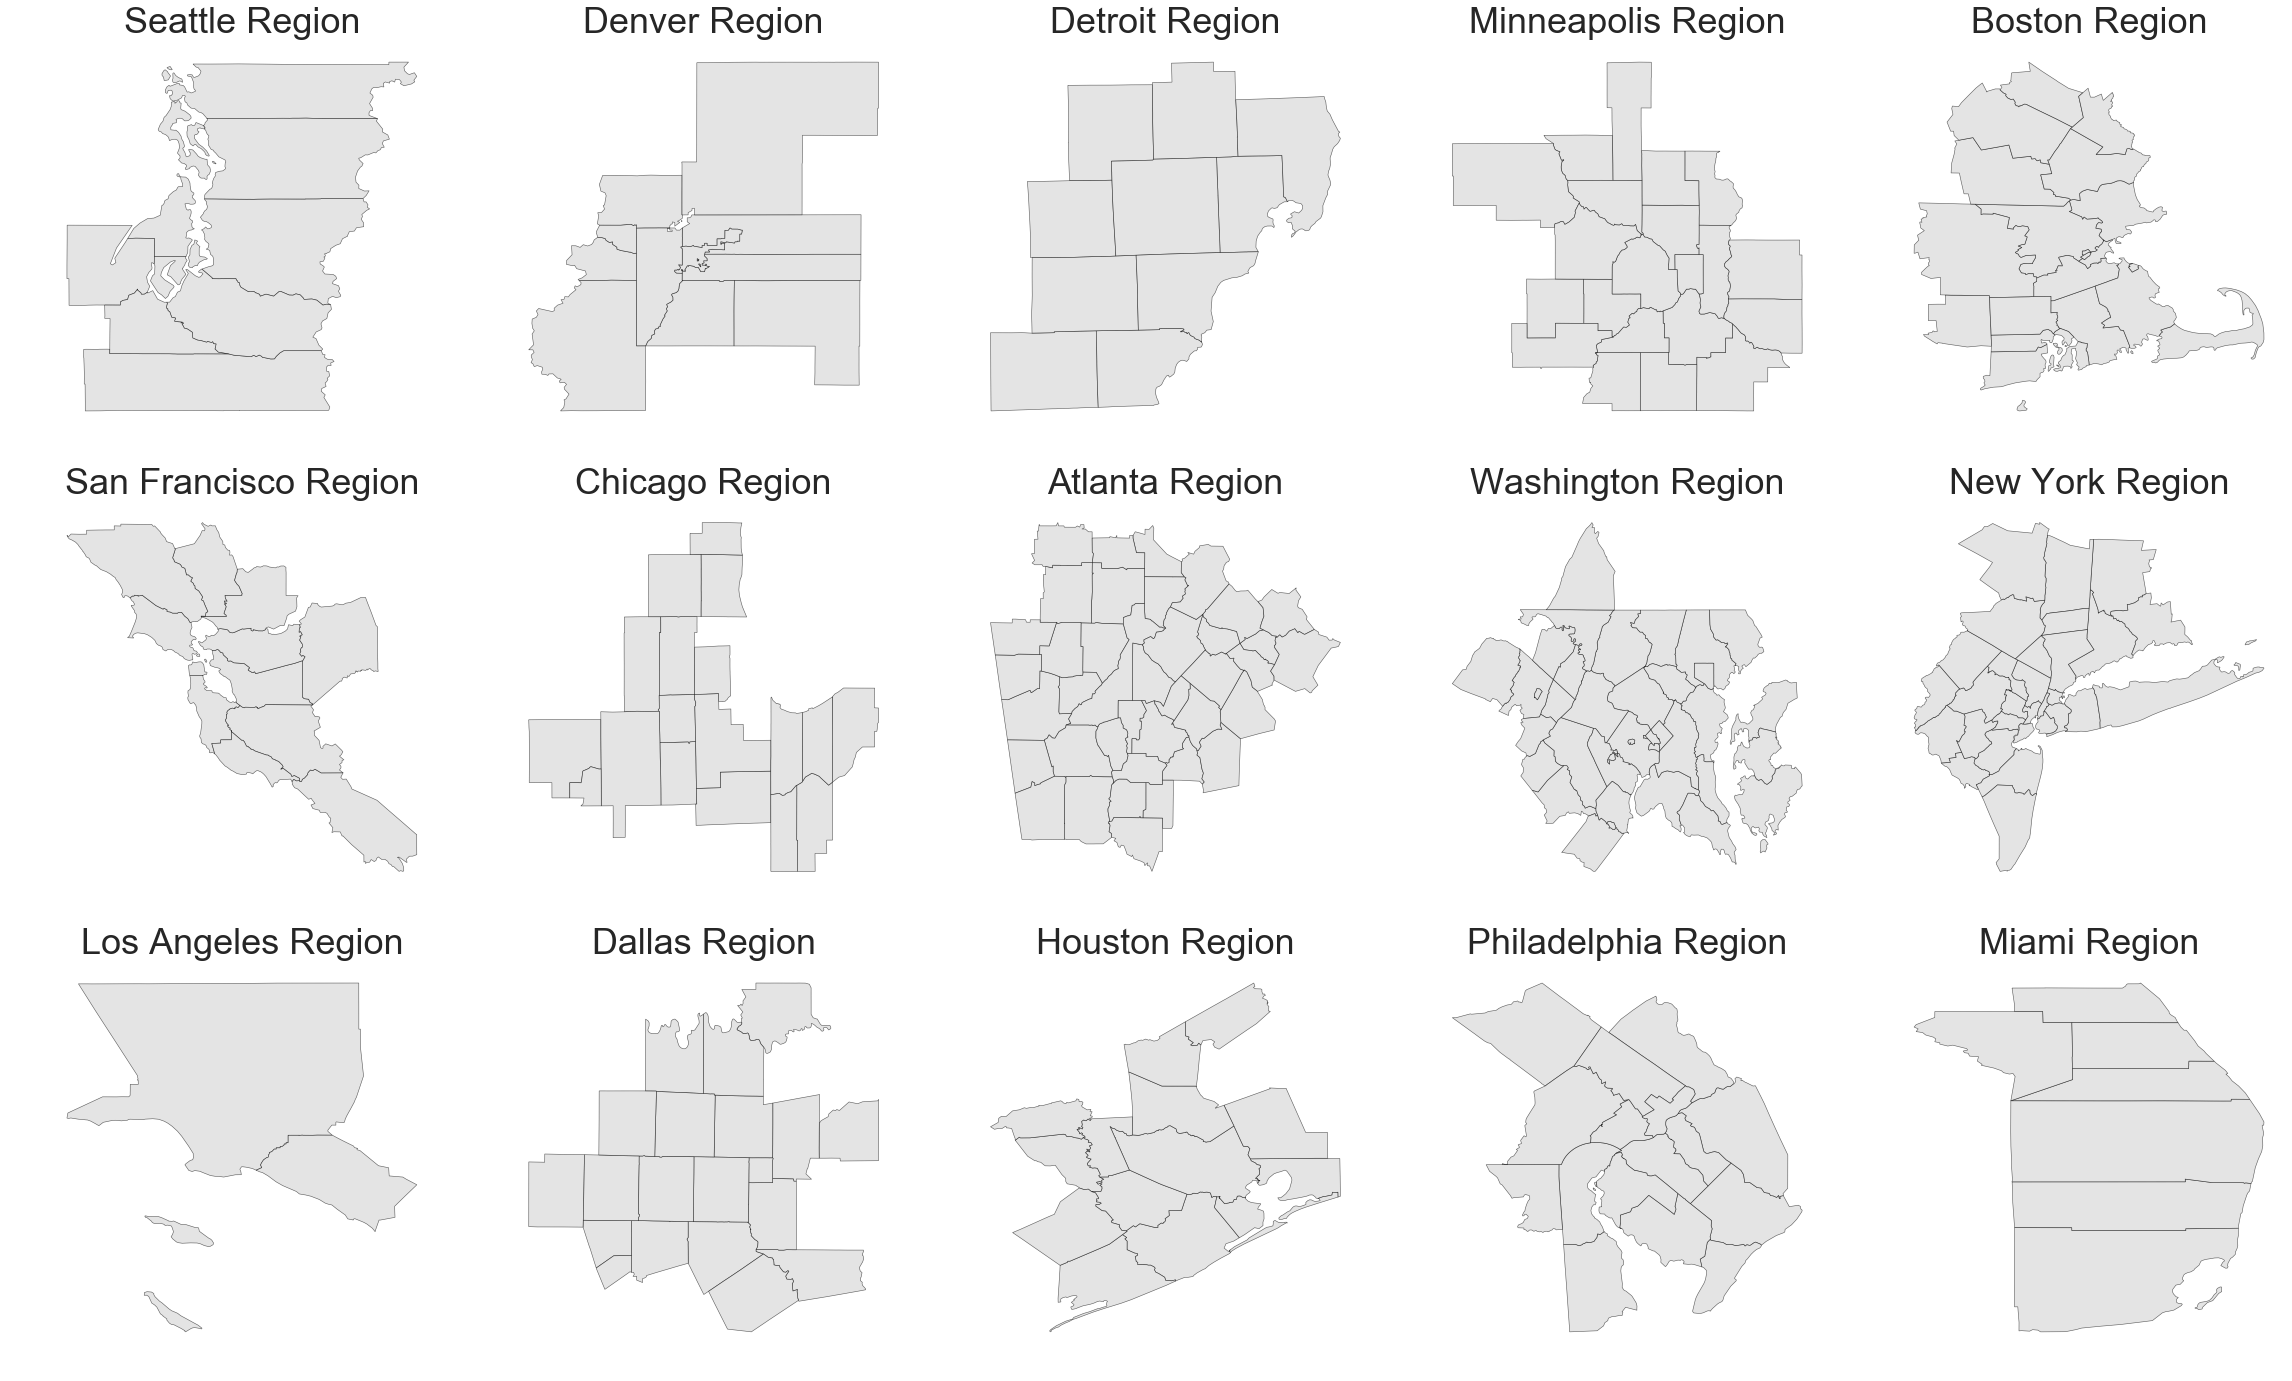

In [29]:
fig = pl.figure(figsize=(40,24))
sns.set_style("whitegrid")

for k in range(len(CSAs_sorted)):
    ax = fig.add_subplot(3,5,k+1)
    Balance_geo[Balance_geo.index == CSAs_sorted[k]].plot(ax=ax, edgecolor='k',
                                    color='lightgrey',linewidth=.6, alpha=0.6);
    ax.set_title('{} Region'.format(CSAs['CSA_short'][CSAs_sorted[k]]), fontsize=36, y=1.015)
    ax.grid(linewidth=0.25)
    ax.axis('off')
    
plt.savefig("exports/CSAsLayout.pdf", transparent=True)

----

# Plotting Housing-Jobs Balance for all CSA's - county level
- 2010
- 2017
- change 10-17

In [30]:
print(Balance_geo['housing/jobs2000'].min())
print(Balance_geo['housing/jobs2000'].max())
print(Balance_geo['housing/jobs2000'].mean())

0.3254804711717297
5.215504631886884
1.157257884002568


In [95]:
Balance_geo[Balance_geo['CSA_name'] == 'Dallas-Fort Worth, TX-OK']['housing/jobs2000']

CSA
206    1.359054
206    1.162549
206    1.194370
206    0.545636
206    1.408415
206    1.175846
206    1.089083
206    2.283327
206    2.025766
206    1.284942
206    1.299496
206    1.422567
206    1.219459
206    1.116632
206    1.676813
206    1.884864
206    1.138629
206    0.756118
206    0.805695
206    1.574245
Name: housing/jobs2000, dtype: float64

## Setting the colormap midpoint as the Housing/Jobs Balance 2000 (0.82) and Housing/Jobs Balance 2017 for all counties (0.86)

Source: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib

In [83]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [136]:
# cmaps for balance 00 and 17

cmap00 = shiftedColorMap(matplotlib.cm.coolwarm, start=0.2,
                            midpoint= 0.64)

cmap17 = shiftedColorMap(matplotlib.cm.coolwarm, start=0.24,
                            midpoint=0.86, 
                            stop=1.48, 
                            name='shiftedcmap')

## Balance 2000

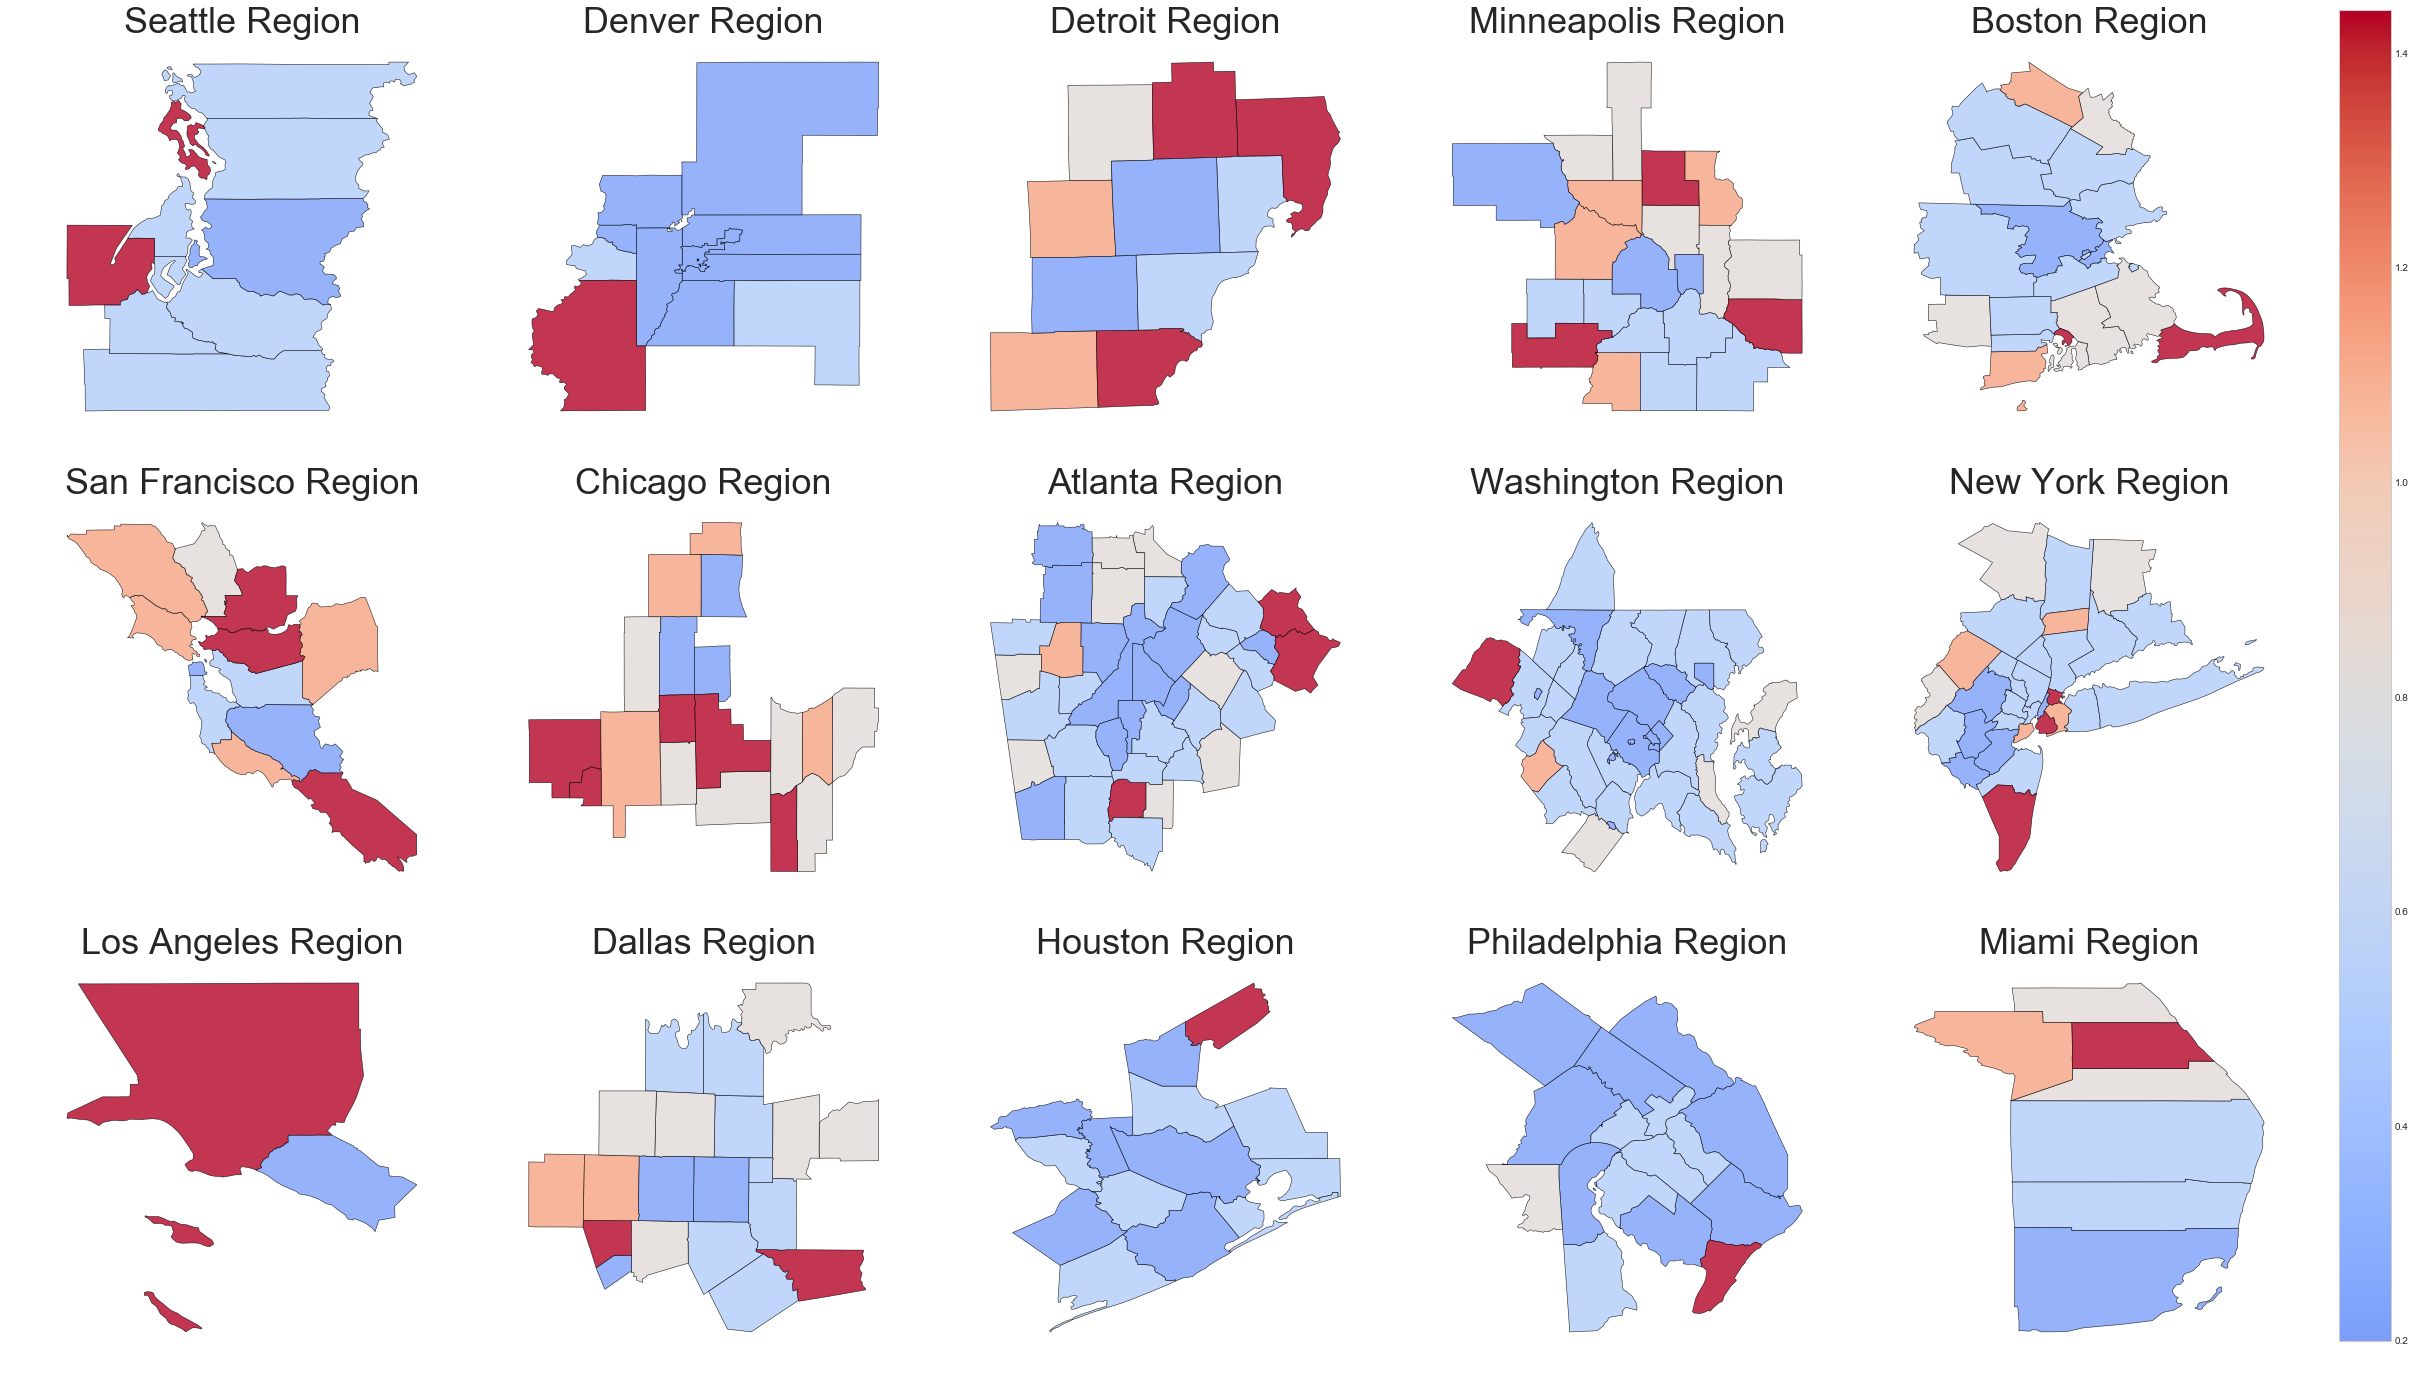

In [137]:
from geopandas.plotting import __pysal_choro

fig = pl.figure(figsize=(40,24))
sns.set_style("whitegrid")
vmin, vmax = 0.2, 1.44

cax = fig.add_axes([0.92, 0.13, 0.018, .77])
sm = plt.cm.ScalarMappable(cmap=cmap00, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax, orientation='vertical')


for k in range(len(CSAs_sorted)):
    ax = fig.add_subplot(3,5,k+1)
    Balance_geo[Balance_geo.index == CSAs_sorted[k]].plot(ax=ax, column='housing/jobs2000', scheme='equal_interval',
                                    cmap=cmap00, edgecolor='k',linewidth=.6, alpha=0.8);
    ax.set_title('{} Region'.format(CSAs['CSA_short'][CSAs_sorted[k]]), fontsize=36, y=1.015)
    ax.grid(linewidth=0.25)
    ax.axis('off')
    
plt.savefig("exports/balance00.pdf", transparent=True)

## Balance 2017

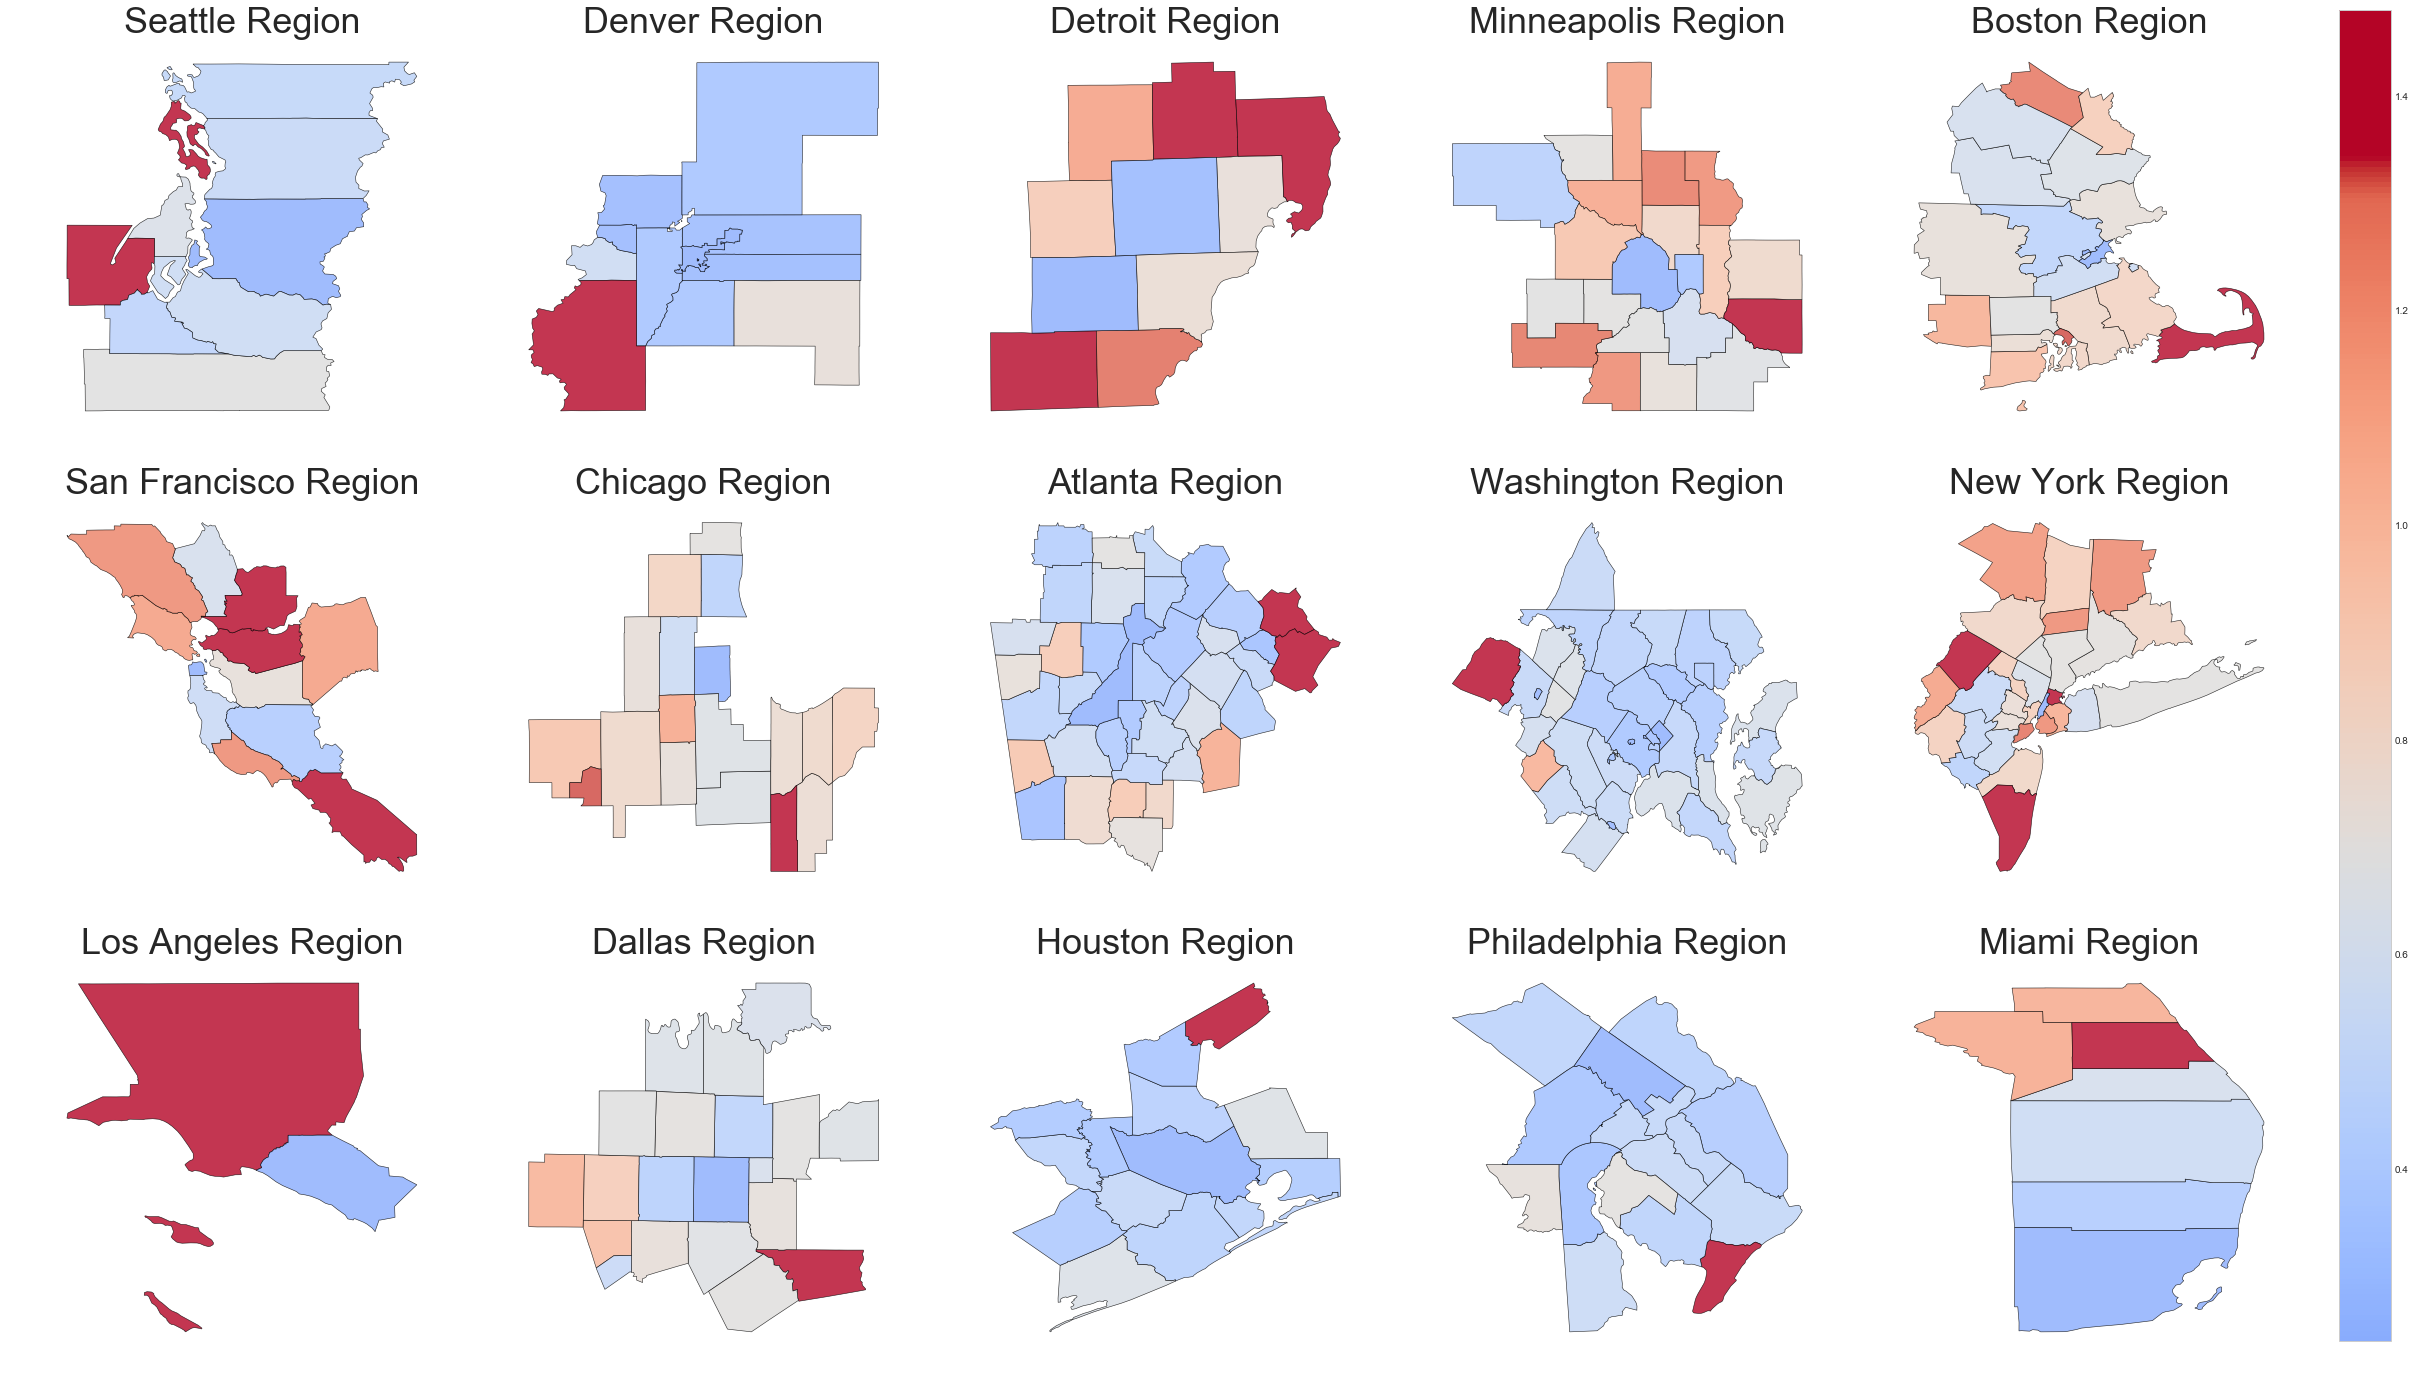

In [94]:
fig = pl.figure(figsize=(40,24))
sns.set_style("whitegrid")
vmin, vmax = 0.24, 1.48

cax = fig.add_axes([0.92, 0.13, 0.018, .77])
sm = plt.cm.ScalarMappable(cmap=cmap17, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax, orientation='vertical', values=None)


# 8 choroplets of seven major felonies + total
for k in range(len(CSAs_sorted)):
    ax = fig.add_subplot(3,5,k+1)
    Balance_geo[Balance_geo.index == CSAs_sorted[k]].plot(ax=ax, column='housing/jobs2017',
                                          cmap=cmap17, edgecolor='k',linewidth=.6, alpha=0.8);
    ax.set_title('{} Region'.format(CSAs['CSA_short'][CSAs_sorted[k]]), fontsize=36, y=1.015)
    ax.grid(linewidth=0.25)
    ax.axis('off')
    
plt.savefig("exports/balance17.pdf", transparent=True)

In [87]:
Balance_geo['balance_ch'].describe()

count    268.000000
mean       0.072460
std        0.200138
min       -0.635836
25%        0.002233
50%        0.058382
75%        0.128549
max        1.052609
Name: balance_ch, dtype: float64

## Balance change 00 vs 17

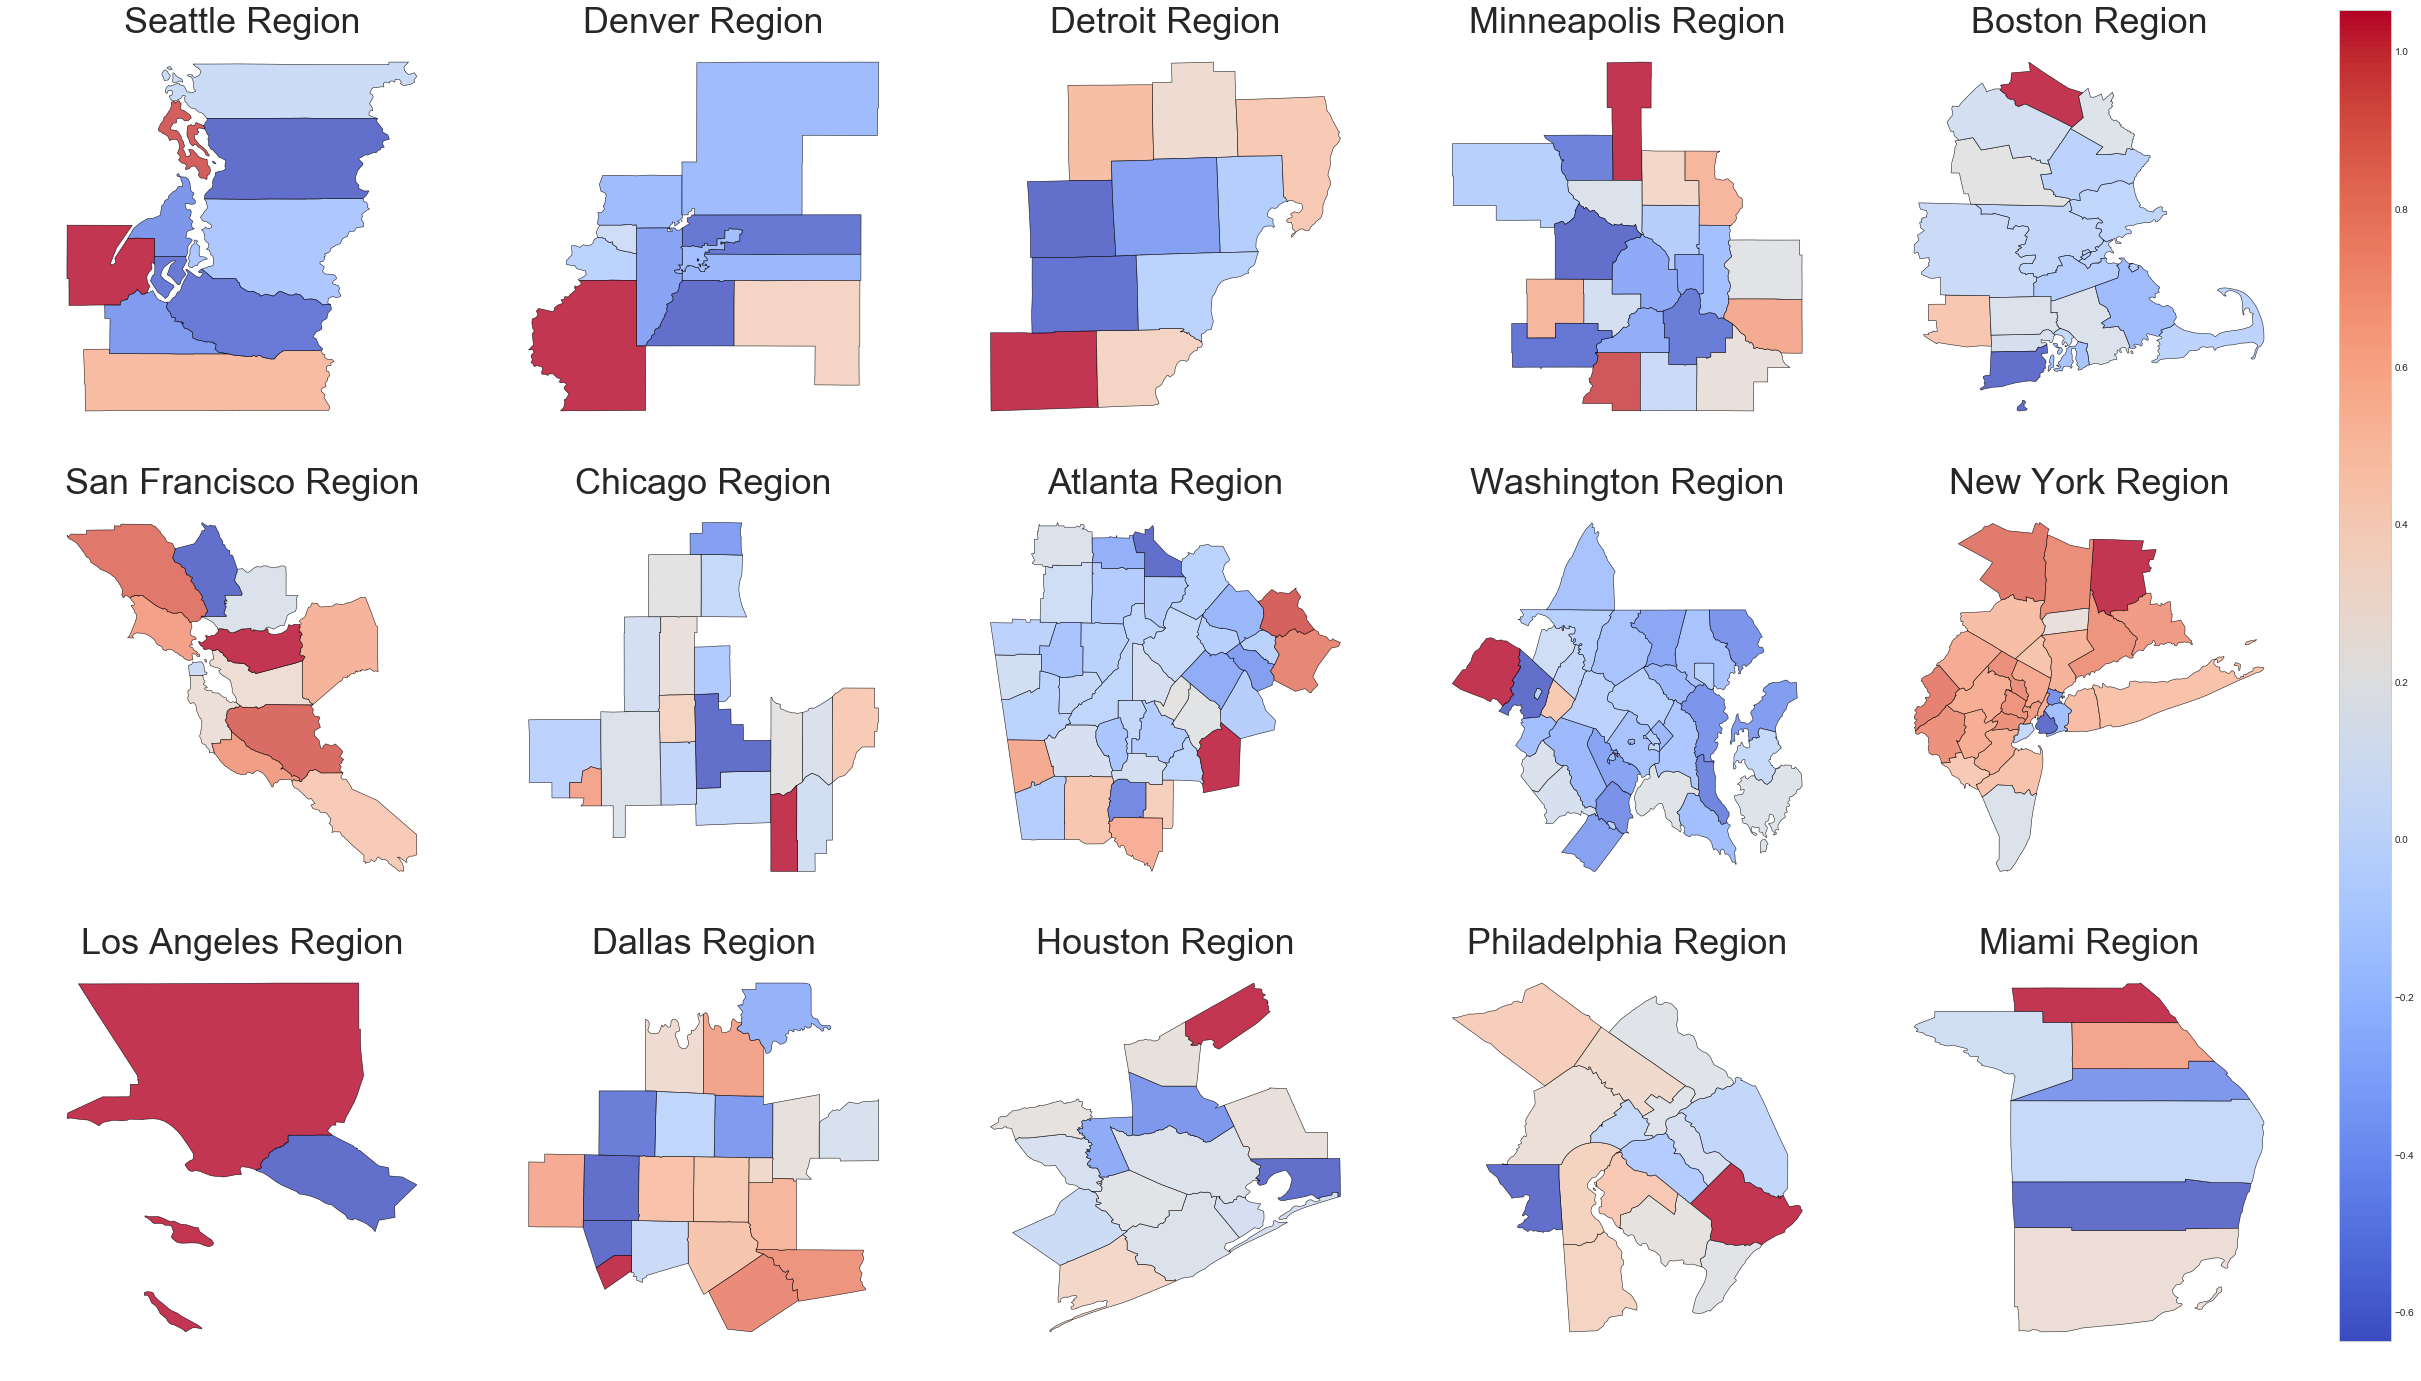

In [88]:
fig = pl.figure(figsize=(40,24))
sns.set_style("whitegrid")
vmin, vmax = Balance_geo['balance_ch'].min(), Balance_geo['balance_ch'].max()

cax = fig.add_axes([0.92, 0.13, 0.018, .77])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax, orientation='vertical', values=None)


# 8 choroplets of seven major felonies + total
for k in range(len(CSAs_sorted)):
    ax = fig.add_subplot(3,5,k+1)
    Balance_geo[Balance_geo.index == CSAs_sorted[k]].plot(ax=ax, column='balance_ch',
                                          cmap='coolwarm', edgecolor='k',linewidth=.6, alpha=0.8);
    ax.set_title('{} Region'.format(CSAs['CSA_short'][CSAs_sorted[k]]), fontsize=36, y=1.015)
    ax.grid(linewidth=0.25)
    ax.axis('off')
    
plt.savefig("exports/balance_ch00-17.pdf", transparent=True)

------

## CSA's

In [56]:
HouJobs = pd.read_excel('BPS_HousingPermits_analysis.xlsx', 
                        sheet_name='HousingJobs_Balance')[:-2].set_index('Name')

HouJobs['housing / jobs 2010'] = HouJobs['housing / jobs 2010'].round(decimals=2)
HouJobs['housing / jobs 2016'] = HouJobs['housing / jobs 2016'].round(decimals=2)
HouJobs['housing / jobs 10-16 NET'] = HouJobs['housing / jobs 10-16 NET'].round(decimals=2)

HouJobs['CSA'] = HouJobs['CSA'].astype(int)

print(HouJobs .shape)
HouJobs 

(15, 5)


,CSA,FullName,housing / jobs 2010,housing / jobs 2016,housing / jobs 10-16 NET
Name,,,,,
New York,408,"New York-Newark, NY-NJ-CT-PA",0.92,0.84,-0.07
Los Angeles,348,"Los Angeles-Long Beach, CA",0.68,0.60,-0.08
Chicago,176,"Chicago-Naperville, IL-IN-WI",0.42,0.39,-0.03
Washington,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",0.84,0.80,-0.04
San Francisco,488,"San Jose-San Francisco-Oakland, CA",0.92,0.77,-0.14
Boston,148,"Boston-Worcester-Providence, MA-RI-NH-CT",0.92,0.84,-0.08
Dallas,206,"Dallas-Fort Worth, TX-OK",0.92,0.81,-0.11
Philadelphia,428,"Philadelphia-Reading-Camden, PA-NJ-DE-MD",0.97,0.93,-0.04
Houston,288,"Houston-The Woodlands, TX",0.94,0.86,-0.08


----
# Census tracts
## Downloaded + cleaned data for years 2000-2017 
_Downloaded and munged by Dara Goldberg_


In [4]:
AlltractsGeo = pd.read_excel("data/ALL Tract Geo Codes.xlsx")
print(AlltractsGeo.shape)
AlltractsGeo.head()

(28066, 5)


,TRACT,CSA,STCO,ST,CO
0,10001041600,428,10001,10,1
1,10003001300,428,10003,10,3
2,10003011100,428,10003,10,3
3,10003011600,428,10003,10,3
4,10003013200,428,10003,10,3


# 2 - Data cleaning and munging

## Total by Industry by Regions
## Total by Industry by Regions - City to region ratio / comparison
## Change by Industry by Regions 
## Change by Industry by Regions - City to region ratio / comparison
## Wages + change by Region (city/region)